We perform all the emcee fits here to investigate the properties of the residuals

In [1]:
import pickle
import os, sys
from astropy import units as u, constants as c
import numpy as np
from matplotlib import pyplot as plt
import emcee, tqdm
from scipy.special import erf

In [2]:
with open("simstack.pkl", "rb") as f:
    results = pickle.load(f)
rkeys = list(results.keys())
bkeys = list(results['seds'].keys())
rkeys, results['wvs'], len(bkeys), bkeys[0]

(['wvs',
  'seds',
  'stds',
  'ngals',
  'z_med',
  'boot',
  'cov',
  'm_med',
  'nd',
  'beams'],
 [24.0, 100.0, 160.0, 250.0, 350.0, 500.0, 850.0],
 96,
 'z=0.01_0.5__logM=9.5_10.0__SF?=0')

In [3]:
if "nd" not in rkeys:
    results['nd'] = {}
    for bkey in bkeys:
        y = results['seds'][bkey]
        yerr_diag = np.diag(results['cov'][bkey])
        results['nd'][bkey] = (y - np.sqrt(yerr_diag)) < 0 
        # wavs for which the data is below the 1-sigma error
    with open("simstack.pkl", "wb") as f:
        pickle.dump(results, f)
        
if "beams" not in rkeys:
    results['beams'] = np.array([1.55, 2.03, 4.66, 9.94, 17.65, 37.30, 5.68]) * 1e-9
    # values from the Viero+22 paper 2203.14312, Viero+13 paper 1304.0446, and 
    # SCUBA beam from https://academic.oup.com/mnras/article/465/2/1789/2454739
    with open("simstack.pkl", "wb") as f:
        pickle.dump(results, f)

In [4]:
def black(nu_in, T):
    # h = 6.623e-34     ; Joule*s
    # k = 1.38e-23      ; Joule/K
    # c = 3e8           ; m/s
    # (2*h*nu_in^3/c^2)*(1/( exp(h*nu_in/k*T) - 1 )) * 10^29

    a0 = 1.4718e-21  # 2*h*10^29/c^2
    a1 = 4.7993e-11  # h/k

    num = a0 * nu_in ** 3.0
    den = np.exp(a1 * np.outer(1.0 / T, nu_in)) - 1.0
    ret = num / den

    return ret

def graybody_fn(theta, x): #=2.0, =1.8):
    A, T, alphain, betain = theta

    c_light = 299792458.0  # m/s

    nu_in = np.array([c_light * 1.e6 / wv for wv in x])
    ng = np.size(A)

    base = 2.0 * (6.626) ** (-2.0 - betain - alphain) * (1.38) ** (3. + betain + alphain) / (2.99792458) ** 2.0
    expo = 34.0 * (2.0 + betain + alphain) - 23.0 * (3.0 + betain + alphain) - 16.0 + 26.0
    K = base * 10.0 ** expo
    w_num = 10 ** A * K * (T * (3.0 + betain + alphain)) ** (3.0 + betain + alphain)
    w_den = (np.exp(3.0 + betain + alphain) - 1.0)
    w_div = w_num / w_den
    nu_cut = (3.0 + betain + alphain) * 0.208367e11 * T
    graybody = np.reshape(10 ** A, (ng, 1)) * nu_in ** np.reshape(betain, (ng, 1)) * black(nu_in, T) / 1000.0
    powerlaw = np.reshape(w_div, (ng, 1)) * nu_in ** np.reshape(-1.0 * alphain, (ng, 1))
    graybody[np.where(nu_in >= np.reshape(nu_cut, (ng, 1)))] = \
        powerlaw[np.where(nu_in >= np.reshape(nu_cut, (ng, 1)))]

    return graybody

graybody_fn((35, 30, 2.0, 1.8), results['wvs'])[0]

array([7.849749348802555e+67, 9.491263797299263e+68,
       6.269838296032081e+68, 2.4115712517811536e+68,
       9.489396082112747e+67, 3.1247471874483694e+67,
       5.195790115816918e+66], dtype=object)

In [5]:
def log_prior(theta, Amin=-38, Amax=-33, Tmin=5, Tmax=32, alpmin=1.0, alpmax=3.0, betmin=1.0, betmax=3.0):
    A, T, alp, bet = theta
    if Amin < A < Amax and Tmin < T < Tmax and alpmin < alp < alpmax and betmin < bet < betmax:
        return 0.0
    return -np.inf

def log_prior_informative(theta, theta0, Amin=-38, Amax=-33, Tmin=5, Tmax=32, error_infl=1.0, \
                          alpmin=1.0, alpmax=3.0, betmin=1.0, betmax=3.0):
    A, T, alp, bet = theta
    A0, T0, alp0, bet0, sigma_T = theta0
    if Amin < A < Amax and Tmin < T < Tmax and sigma_T is not None and alpmin < alp < alpmax and betmin < bet < betmax:
        lp = -0.5 * (np.sum((T - T0) ** 2 / (sigma_T * error_infl) ** 2)) + \
                np.log(1.0 / (np.sqrt(2 * np.pi) * (sigma_T * error_infl) ** 2))
        return lp
    return -np.inf

def log_likelihood(theta, x, y, yerr, nd, sig_upp_lim=3.0):
    x_d, y_d, x_nd, y_nd = x[~nd], y[~nd], x[nd], y[nd] # 1d arrays
    for i in np.where(nd)[::-1]:
        yerr_d = np.delete(yerr, i, axis=0)
        yerr_d = np.delete(yerr_d, i, axis=1)
    nd_ulim = np.diag(yerr)[nd] # upper limit
    
    model_d = graybody_fn(theta, x_d)[0]
    dy = y_d - model_d
    ll_d = -.5 * (np.matmul(dy, np.matmul(np.linalg.inv(yerr_d), dy)) \
        + len(dy) * np.log(2 * np.pi) + np.log(np.linalg.det(yerr_d)))
    
    model_nd = graybody_fn(theta, x_nd)[0]
    ll_nd = np.sum(np.log(np.sqrt(np.pi / 2 * np.sqrt(nd_ulim)) * (
        erf((np.sqrt(nd_ulim) * sig_upp_lim - model_nd) / np.sqrt(2 * nd_ulim)) + 
        erf(model_nd / np.sqrt(2 * nd_ulim)))))
    
    if not np.isfinite(ll_d) or not np.isfinite(ll_nd):
        return -np.inf
    
    return ll_d + ll_nd

def log_probability(theta, x, y, yerr, nd, theta0=None):
    # if theta0 is provided, use informative prior
    lp = log_prior(theta) if theta0 is None else log_prior_informative(theta, theta0)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr, nd)

In [6]:
# Viero+22 uses their informative prior in these bins
informative_prior = ['z=1.5_2.0__logM=9.5_10.0__SF?=1',
                    'z=2.0_2.5__logM=9.5_10.0__SF?=1',
                    'z=2.0_2.5__logM=10.0_10.5__SF?=1',
                    'z=3.0_3.5__logM=9.5_10.0__SF?=1',
                    'z=3.5_4.0__logM=10.0_10.5__SF?=1',
                    'z=5.0_6.0__logM=9.5_10.0__SF?=1',
                    'z=6.0_8.0__logM=10.5_11.0__SF?=1',
                    'z=6.0_8.0__logM=11.0_12.0__SF?=1']

ndim, nwalkers = 4, 64
pertubation = 1e-1
nsteps, burn_in = 15000, 3000

In [28]:
emcee_results = {}
overwrite = True

for bkey in bkeys:
    out_file = f"../outs/20240602_emcee/{bkey}.pkl"
    if not overwrite and os.path.exists(out_file):
        with open(out_file, "rb") as f:
            emcee_results[bkey] = pickle.load(f)
        continue
    
    if "__SF?=1" not in bkey:
        # continue
        pass
    
    pertubation = 3e-2
    x = np.array(results['wvs'])
    y = np.array(results['seds'][bkey])
    nd = np.array(results['nd'][bkey])
    z_median = results['z_med'][bkey]
    m_median = results['m_med'][bkey]
    
    # implement MIPS penalty as in Viero+22
    if (z_median > 1.5) & (z_median < 2) & (m_median >= 10):
        mips_penalty = 4
    elif (z_median > 2.0) & (z_median < 2.5) & (m_median >= 10):
        mips_penalty = 2.5
    elif (z_median > 1.5) & (z_median < 2.5):
        mips_penalty = 1
    elif (z_median > 0.5) & (z_median < 3):
        mips_penalty = 2
    else:
        mips_penalty = 1
    print("mips penalty:", mips_penalty)
    yboot = results['boot'][bkey].copy()
    yboot[:, 0] *= mips_penalty
    yerr = np.cov(yboot, rowvar=False)
    
    use_informative_prior = bkey in informative_prior
    print("use informative prior:", use_informative_prior)
    
    Tmodel = (22.5 + 5.8 * z_median + 0.4 * z_median ** 2) / (1 + z_median)
    Amodel = -47 - z_median*0.05 + 11 * (m_median / 10)
    sigma_T = 0.25 if use_informative_prior else None
    print("theta0:", Amodel, Tmodel, Tmodel * (1 + z_median), sigma_T)
    
    theta0 = (Amodel, Tmodel, 2.0, 1.8) if not use_informative_prior else (Amodel, Tmodel, 2.0, 1.8, sigma_T)

    initial = theta0[:ndim] + pertubation * np.random.randn(nwalkers, ndim)
    
    args = (x, y, yerr, nd) if not use_informative_prior else (x, y, yerr, nd, theta0)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=args)
    sampler.run_mcmc(initial, nsteps, progress=True)
    
    samples = sampler.get_chain(discard=burn_in, flat=True)
    As, Ts = samples[:, 0], samples[:, 1]
    alps, bets = samples[:, 2], samples[:, 3]
    Abest, Tbest = np.median(As), np.median(Ts)
    alp_best, bet_best = np.median(alps), np.median(bets)
    print("best:", Abest, Tbest, Tbest * (1 + z_median))
    print("best:", alp_best, bet_best)
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    for i, val in enumerate([As, Ts, alps, bets]):
        ax = axs.flatten()[i]
        ax.hist(val, bins=50)
    plt.show()
    plt.close()
    
    # C_best = graybody_fn((Abest, Tbest), x)[0]
    C_best = graybody_fn((Abest, Tbest, alp_best, bet_best), x)[0]
    C_samples = np.array([graybody_fn(val, x)[0] for val in samples])
    C_std = np.std(C_samples, axis=0)
    
    plt.figure()
    plt.fill_between(x, C_best - C_std, C_best + C_std, alpha=0.5)
    plt.errorbar(x[~nd], y[~nd], yerr=np.sqrt(np.diag(yerr))[~nd], fmt='s')
    plt.scatter(x[nd], np.sqrt(np.diag(yerr))[nd] * 3.0, c='r', marker='o')
    plt.loglog()
    plt.show()
    plt.close()
    
    residuals = y - C_best
    sig_residuals = np.sqrt(np.diag(yerr) + C_std ** 2)
    
    plt.figure()
    plt.errorbar(x[~nd], residuals[~nd], yerr=sig_residuals[~nd], fmt='x')
    plt.errorbar(x[nd], residuals[nd], yerr=sig_residuals[nd], fmt='x', color='r')
    plt.axhline(0, color='k', ls='--')
    plt.xscale('log')
    plt.show()
    plt.close()
    
    emcee_results[bkey] = (Abest, Tbest, C_best, C_std, samples, residuals, sig_residuals, nd)
    
    with open(out_file, "wb") as f:
        pickle.dump(emcee_results[bkey], f)

z=4.0_5.0__logM=10.0_10.5__SF?=1 1528 4.51455
z=5.0_6.0__logM=9.5_10.0__SF?=1 1432 5.370150000000001
z=5.0_6.0__logM=11.0_12.0__SF?=1 88 5.259
z=6.0_8.0__logM=10.5_11.0__SF?=1 127 6.9251
z=8.0_10.0__logM=11.0_12.0__SF?=1 68 9.1381


In [30]:
len(emcee_results.keys())

43

In [54]:
snrs = np.empty((len(results['wvs']), 0))
for bkey in emcee_results.keys():
    snrs = np.hstack((snrs, np.array([emcee_results[bkey][-3] / emcee_results[bkey][-2]]).T))
snrs.shape

(7, 43)

In [67]:
print(np.mean(snrs, axis=1), np.std(snrs, axis=1))

[ 0.36078641 -0.15903528 -0.48080205  0.63547418  0.02233577 -0.15612944
  0.12170884] [0.90627118 2.07834229 2.54339004 2.2730233  3.10617686 4.52683886
 2.77463492]


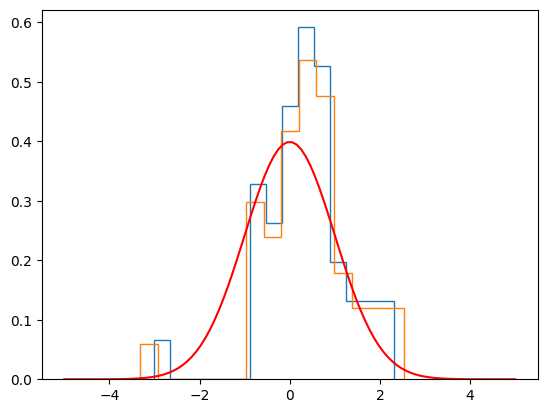

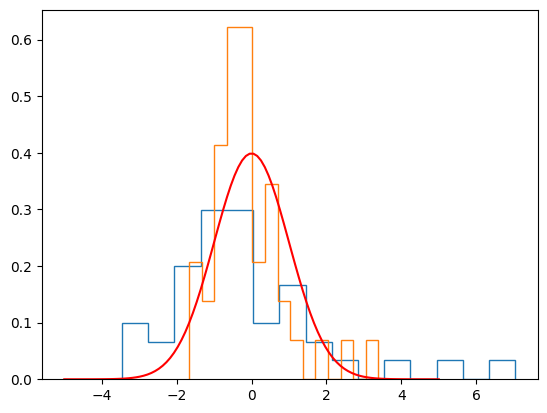

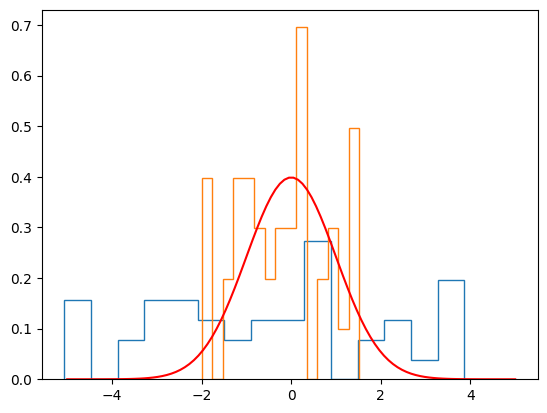

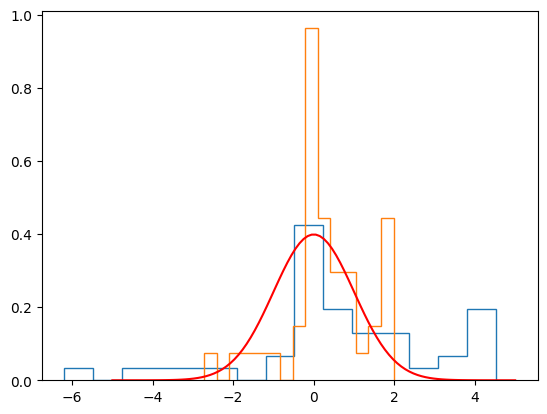

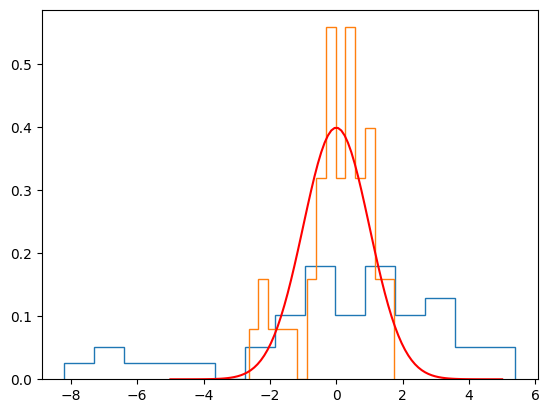

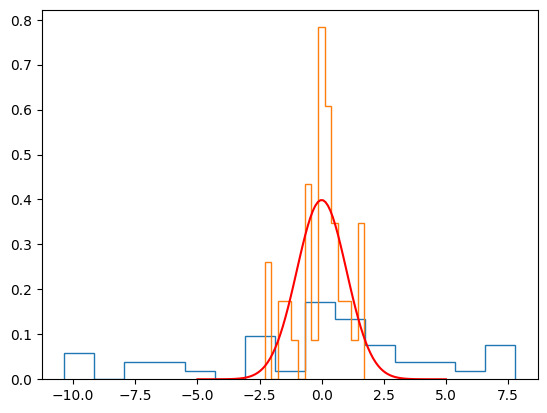

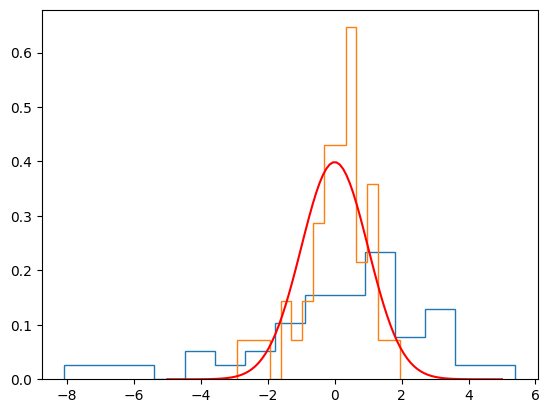

In [72]:
for ind in range(snrs.shape[0]):
    plt.figure()
    plt.hist(snrs[ind], bins=15, density=True, histtype='step')
    plt.hist(snrs[ind] / np.std(snrs[ind]), bins=15, density=True, histtype='step')
    # plot a gaussian with the mean 0 and std 1
    x = np.linspace(-5, 5, 100)
    plt.plot(x, np.exp(-0.5 * x ** 2) / np.sqrt(2 * np.pi), 'r-')
    plt.show()
    plt.close()

In [73]:
np.std(snrs, axis=1)

array([0.90627118, 2.07834229, 2.54339004, 2.2730233 , 3.10617686,
       4.52683886, 2.77463492])

In [ ]:
1